In [1]:
# Add parent directory to Python path
import sys
from pathlib import Path
sys.path.append(str(Path('../').resolve()))

# Core libraries
import pandas as pd
import numpy as np
from datetime import datetime, timedelta, date
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-v0_8')

# Statistical analysis
from scipy import stats
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Database and utilities
import sqlalchemy
from dotenv import load_dotenv
from src.database import get_database_connection

# Load environment
load_dotenv()

print("✅ Environment loaded and libraries imported successfully!")
print("🚀 Phase 1D: Trading Strategy Development Ready!")

# Trading strategy configuration
SYMBOLS = ['INTC', 'AMD', 'NVDA']
PRIMARY_SYMBOL = 'INTC'
LOOKBACK_WINDOW = 20  # Days for strategy calculations
MIN_POSITION_SIZE = 0.01  # Minimum position as fraction of portfolio
MAX_POSITION_SIZE = 0.25  # Maximum position as fraction of portfolio
TRANSACTION_COST = 0.001  # 0.1% transaction cost per trade

print(f"📊 Target symbols: {SYMBOLS}")
print(f"🎯 Primary symbol: {PRIMARY_SYMBOL}")
print(f"⚙️  Strategy parameters configured")


✅ Environment loaded and libraries imported successfully!
🚀 Phase 1D: Trading Strategy Development Ready!
📊 Target symbols: ['INTC', 'AMD', 'NVDA']
🎯 Primary symbol: INTC
⚙️  Strategy parameters configured


In [2]:
def load_complete_dataset():
    """
    Load the complete historical dataset with market data, technical indicators,
    and sentiment data for all symbols.
    
    Returns:
        dict: Dictionary containing DataFrames for each data type
    """
    try:
        engine = get_database_connection()
        
        # Load market data with technical indicators
        market_tech_query = """
        SELECT 
            s.symbol,
            md.trade_date,
            md.open_price,
            md.high_price,
            md.low_price,
            md.close_price,
            md.volume,
            ti.sma_1, ti.sma_2, ti.sma_3, ti.sma_4, ti.sma_5, ti.sma_6, ti.sma_7, ti.sma_8,
            ti.roc_1, ti.roc_2, ti.roc_3, ti.roc_4, ti.roc_5, ti.roc_6, ti.roc_7, ti.roc_8
        FROM symbols s
        JOIN market_data md ON s.id = md.symbol_id
        LEFT JOIN technical_indicators ti ON s.id = ti.symbol_id AND md.trade_date = ti.trade_date
        WHERE s.symbol IN ('INTC', 'AMD', 'NVDA')
        ORDER BY s.symbol, md.trade_date
        """
        
        market_tech_df = pd.read_sql(market_tech_query, engine)
        market_tech_df['trade_date'] = pd.to_datetime(market_tech_df['trade_date'])
        
        # Load sentiment data (if available)
        sentiment_df = pd.DataFrame()  # Initialize empty
        
        try:
            sentiment_query = """
            SELECT 
                s.symbol,
                sd.analysis_date,
                sd.smo_score,
                sd.smd_score,
                sd.smc_score,
                sd.sms_score,
                sd.sdc_score,
                sd.news_count,
                sd.analysis_summary
            FROM symbols s
            JOIN sentiment_data sd ON s.id = sd.symbol_id
            WHERE s.symbol IN ('INTC', 'AMD', 'NVDA')
            ORDER BY s.symbol, sd.analysis_date
            """
            
            sentiment_df = pd.read_sql(sentiment_query, engine)
            if not sentiment_df.empty:
                sentiment_df['analysis_date'] = pd.to_datetime(sentiment_df['analysis_date'])
                print("✅ Sentiment data found and loaded")
            else:
                print("⚠️  No sentiment data available")
                
        except Exception as sentiment_error:
            print(f"⚠️  Sentiment data not available: {str(sentiment_error).split('LINE')[0].strip()}")
            print("📊 Proceeding with technical analysis only")
        
        # Create symbol-separated datasets
        datasets = {}
        
        for symbol in SYMBOLS:
            symbol_data = market_tech_df[market_tech_df['symbol'] == symbol].copy()
            symbol_data.set_index('trade_date', inplace=True)
            symbol_data.drop('symbol', axis=1, inplace=True)
            
            # Add sentiment data if available
            if not sentiment_df.empty:
                symbol_sentiment = sentiment_df[sentiment_df['symbol'] == symbol].copy()
                symbol_sentiment.set_index('analysis_date', inplace=True)
                symbol_sentiment.drop('symbol', axis=1, inplace=True)
                
                # Merge sentiment with market data (forward fill sentiment)
                symbol_data = symbol_data.join(symbol_sentiment, how='left')
                symbol_data[['smo_score', 'smd_score', 'smc_score', 'sms_score', 'sdc_score']] = \
                    symbol_data[['smo_score', 'smd_score', 'smc_score', 'sms_score', 'sdc_score']].fillna(method='ffill')
            
            datasets[symbol] = symbol_data
        
        print(f"✅ Dataset loaded successfully!")
        print(f"📊 Data coverage per symbol:")
        
        for symbol, data in datasets.items():
            print(f"  • {symbol}: {len(data)} trading days")
            print(f"    Date range: {data.index.min().date()} to {data.index.max().date()}")
            if 'smo_score' in data.columns:
                sentiment_coverage = data['smo_score'].notna().sum()
                print(f"    Sentiment coverage: {sentiment_coverage} days ({sentiment_coverage/len(data)*100:.1f}%)")
            print()
        
        return datasets
        
    except Exception as e:
        print(f"❌ Error loading dataset: {e}")
        return {}

# Load the complete dataset
print("🔄 Loading complete historical dataset...")
datasets = load_complete_dataset()

# Check strategy operating mode
if datasets:
    has_sentiment = False
    for data in datasets.values():
        if 'smo_score' in data.columns and data['smo_score'].notna().sum() > 0:
            has_sentiment = True
            break
    
    if has_sentiment:
        print("🎯 Strategy Mode: Multi-Factor (Technical + Sentiment Analysis)")
    else:
        print("📊 Strategy Mode: Technical Analysis Only")
        print("ℹ️  Note: Run Phase 1B to collect sentiment data for multi-factor strategies")

# Verify data quality
if datasets:
    print("📈 Sample data preview (INTC latest 5 days):")
    display_columns = ['close_price', 'volume', 'sma_5', 'roc_5']
    if 'smo_score' in datasets[PRIMARY_SYMBOL].columns:
        display_columns.extend(['smo_score', 'smd_score', 'smc_score'])
    
    if PRIMARY_SYMBOL in datasets:
        display(datasets[PRIMARY_SYMBOL][display_columns].tail(5).round(4))
else:
    print("⚠️  No data loaded - check database connection and data availability")


🔄 Loading complete historical dataset...
⚠️  Sentiment data not available: (psycopg2.errors.UndefinedTable) relation "sentiment_data" does not exist
📊 Proceeding with technical analysis only
✅ Dataset loaded successfully!
📊 Data coverage per symbol:
  • INTC: 273 trading days
    Date range: 2024-05-24 to 2025-06-27

  • AMD: 273 trading days
    Date range: 2024-05-24 to 2025-06-27

  • NVDA: 273 trading days
    Date range: 2024-05-24 to 2025-06-27

📊 Strategy Mode: Technical Analysis Only
ℹ️  Note: Run Phase 1B to collect sentiment data for multi-factor strategies
📈 Sample data preview (INTC latest 5 days):


,close_price,volume,sma_5,roc_5
trade_date,,,,
2025-06-23,21.19,81461000,21.060,5.2135
2025-06-24,22.55,130368700,21.422,8.7271
2025-06-25,22.20,64975100,21.702,6.7308
2025-06-26,22.50,63229300,21.904,4.6999
2025-06-27,22.69,95431800,22.226,7.6376


In [3]:
class TradingSignalGenerator:
    """
    Advanced trading signal generator combining sentiment analysis with technical indicators.
    
    Generates multi-factor trading signals using:
    - 5-category sentiment scores (SMO, SMD, SMC, SMS, SDC)
    - Technical indicators (SMA crossovers, ROC momentum)
    - Multi-symbol competitive analysis
    - Risk-adjusted position sizing
    """
    
    def __init__(self, datasets, primary_symbol='INTC'):
        self.datasets = datasets
        self.primary_symbol = primary_symbol
        self.signals = {}
        
    def calculate_sentiment_composite(self, data, weights=None):
        """
        Calculate composite sentiment score from 5-category analysis.
        
        Args:
            data (pd.DataFrame): Symbol data with sentiment scores
            weights (dict): Custom weights for sentiment categories
            
        Returns:
            pd.Series: Composite sentiment score
        """
        if weights is None:
            # Default weights based on trading impact importance
            weights = {
                'smo_score': 0.25,  # Market open impact
                'smd_score': 0.20,  # Mid-day impact  
                'smc_score': 0.25,  # Market close impact
                'sms_score': 0.15,  # Sector sentiment
                'sdc_score': 0.15   # Competitive pressure
            }
        
        sentiment_columns = ['smo_score', 'smd_score', 'smc_score', 'sms_score', 'sdc_score']
        available_sentiment_cols = [col for col in sentiment_columns if col in data.columns]
        
        if available_sentiment_cols:
            print(f"📊 Using {len(available_sentiment_cols)} sentiment categories: {available_sentiment_cols}")
            composite = pd.Series(0.0, index=data.index)
            total_weight = 0
            
            for col, weight in weights.items():
                if col in data.columns:
                    composite += data[col].fillna(0) * weight
                    total_weight += weight
            
            # Normalize if not all sentiment categories available
            if total_weight > 0 and total_weight != 1.0:
                composite = composite / total_weight
                
            return composite
        else:
            # Return neutral sentiment if no sentiment data
            print("⚠️  No sentiment data available - using neutral sentiment (0.0)")
            return pd.Series(0.0, index=data.index)
    
    def calculate_technical_signals(self, data):
        """
        Calculate technical trading signals from price and indicators.
        
        Args:
            data (pd.DataFrame): Symbol data with technical indicators
            
        Returns:
            dict: Dictionary of technical signals
        """
        signals = {}
        
        # SMA Crossover Signals
        if 'sma_5' in data.columns and 'sma_20' in data.columns:
            # Short-term vs medium-term trend
            signals['sma_5_20_signal'] = np.where(
                data['sma_5'] > data['sma_20'], 1, -1
            )
        elif 'sma_3' in data.columns and 'sma_8' in data.columns:
            # Use available SMAs
            signals['sma_3_8_signal'] = np.where(
                data['sma_3'] > data['sma_8'], 1, -1
            )
        
        # ROC Momentum Signals
        if 'roc_5' in data.columns:
            # Strong momentum threshold
            signals['roc_momentum'] = np.where(
                data['roc_5'] > 2.0, 1,  # Strong positive momentum
                np.where(data['roc_5'] < -2.0, -1, 0)  # Strong negative momentum
            )
        
        # Price vs SMA Position Signal
        if 'sma_5' in data.columns:
            signals['price_vs_sma'] = np.where(
                data['close_price'] > data['sma_5'], 1, -1
            )
        
        # Volume Confirmation
        if 'volume' in data.columns:
            volume_ma = data['volume'].rolling(20, min_periods=5).mean()
            signals['volume_confirmation'] = np.where(
                data['volume'] > volume_ma * 1.2, 1,  # High volume
                np.where(data['volume'] < volume_ma * 0.8, -1, 0)  # Low volume
            )
        
        return signals
    
    def calculate_competitive_intelligence(self, primary_data, competitor_data):
        """
        Calculate competitive intelligence signals using multi-symbol analysis.
        
        Args:
            primary_data (pd.DataFrame): Primary symbol data
            competitor_data (dict): Competitor symbol datasets
            
        Returns:
            pd.Series: Competitive advantage signal
        """
        if not competitor_data:
            return pd.Series(0.0, index=primary_data.index)
        
        # Calculate relative performance vs competitors
        primary_returns = primary_data['close_price'].pct_change(5)  # 5-day returns
        
        competitor_returns = []
        for symbol, data in competitor_data.items():
            if symbol != self.primary_symbol and len(data) > 0:
                comp_returns = data['close_price'].pct_change(5)
                competitor_returns.append(comp_returns)
        
        if competitor_returns:
            # Average competitor performance
            avg_competitor_returns = pd.concat(competitor_returns, axis=1).mean(axis=1)
            
            # Align indices
            common_index = primary_returns.index.intersection(avg_competitor_returns.index)
            primary_aligned = primary_returns.reindex(common_index)
            competitor_aligned = avg_competitor_returns.reindex(common_index)
            
            # Relative performance signal
            relative_performance = primary_aligned - competitor_aligned
            
            # Generate signal based on outperformance
            competitive_signal = np.where(
                relative_performance > 0.02, 1,    # Outperforming by 2%+
                np.where(relative_performance < -0.02, -1, 0)  # Underperforming by 2%+
            )
            
            return pd.Series(competitive_signal, index=common_index).reindex(primary_data.index, fill_value=0)
        
        return pd.Series(0.0, index=primary_data.index)
    
    def generate_master_signal(self, symbol, sentiment_weight=0.4, technical_weight=0.4, competitive_weight=0.2):
        """
        Generate master trading signal combining all factors.
        
        Args:
            symbol (str): Symbol to generate signals for
            sentiment_weight (float): Weight for sentiment signals
            technical_weight (float): Weight for technical signals
            competitive_weight (float): Weight for competitive signals
            
        Returns:
            pd.DataFrame: Complete signal analysis
        """
        if symbol not in self.datasets:
            print(f"❌ No data available for {symbol}")
            return pd.DataFrame()
        
        data = self.datasets[symbol].copy()
        
        # Calculate individual signal components
        sentiment_composite = self.calculate_sentiment_composite(data)
        technical_signals = self.calculate_technical_signals(data)
        
        # Check if sentiment data is actually available (not all zeros)
        has_sentiment_data = sentiment_composite.abs().sum() > 0
        
        # Adjust weights if no sentiment data available
        if not has_sentiment_data:
            print(f"⚙️  Adjusting weights for {symbol} (no sentiment data):")
            print(f"   Technical weight: {technical_weight:.1f} → {technical_weight + sentiment_weight:.1f}")
            print(f"   Competitive weight: {competitive_weight:.1f} → {competitive_weight:.1f}")
            technical_weight += sentiment_weight  # Add sentiment weight to technical
            sentiment_weight = 0.0
        
        # Competitive intelligence (only for primary symbol)
        if symbol == self.primary_symbol:
            competitor_data = {k: v for k, v in self.datasets.items() if k != symbol}
            competitive_signal = self.calculate_competitive_intelligence(data, competitor_data)
        else:
            competitive_signal = pd.Series(0.0, index=data.index)
        
        # Create signal DataFrame
        signal_df = pd.DataFrame(index=data.index)
        signal_df['close_price'] = data['close_price']
        signal_df['sentiment_composite'] = sentiment_composite
        signal_df['competitive_signal'] = competitive_signal
        
        # Add technical signals
        for signal_name, signal_values in technical_signals.items():
            signal_df[signal_name] = signal_values
        
        # Calculate technical composite
        technical_cols = [col for col in signal_df.columns if col.endswith('_signal') or col == 'roc_momentum']
        if technical_cols:
            signal_df['technical_composite'] = signal_df[technical_cols].mean(axis=1)
            print(f"📊 Technical indicators used: {technical_cols}")
        else:
            signal_df['technical_composite'] = 0.0
            print("⚠️  No technical indicators available")
        
        # Master signal calculation
        signal_df['master_signal'] = (
            sentiment_composite * sentiment_weight +
            signal_df['technical_composite'] * technical_weight +
            competitive_signal * competitive_weight
        )
        
        # Normalize master signal to [-1, 1] range
        signal_df['master_signal'] = np.clip(signal_df['master_signal'], -1, 1)
        
        # Generate position signals
        signal_df['position_signal'] = np.where(
            signal_df['master_signal'] > 0.3, 1,      # Strong buy
            np.where(signal_df['master_signal'] > 0.1, 0.5,   # Weak buy
                np.where(signal_df['master_signal'] < -0.3, -1,     # Strong sell
                    np.where(signal_df['master_signal'] < -0.1, -0.5, 0)))  # Weak sell
        )
        
        return signal_df
    
    def generate_all_signals(self):
        """Generate trading signals for all symbols."""
        print("🔄 Generating trading signals for all symbols...")
        
        for symbol in SYMBOLS:
            print(f"📊 Calculating signals for {symbol}...")
            signals = self.generate_master_signal(symbol)
            
            if not signals.empty:
                self.signals[symbol] = signals
                print(f"✅ {symbol}: {len(signals)} signal points generated")
                
                # Signal statistics
                buy_signals = (signals['position_signal'] > 0).sum()
                sell_signals = (signals['position_signal'] < 0).sum()
                neutral_signals = (signals['position_signal'] == 0).sum()
                
                print(f"   Buy signals: {buy_signals} ({buy_signals/len(signals)*100:.1f}%)")
                print(f"   Sell signals: {sell_signals} ({sell_signals/len(signals)*100:.1f}%)")
                print(f"   Neutral: {neutral_signals} ({neutral_signals/len(signals)*100:.1f}%)")
                print()
            else:
                print(f"⚠️  No signals generated for {symbol}")
        
        return self.signals

# Initialize signal generator
if datasets:
    print("🚀 Initializing Trading Signal Generator...")
    signal_generator = TradingSignalGenerator(datasets, PRIMARY_SYMBOL)
    
    # Generate signals for all symbols
    all_signals = signal_generator.generate_all_signals()
    
    if all_signals:
        print("📈 Signal generation complete! Sample signals for INTC:")
        sample_columns = ['close_price', 'sentiment_composite', 'technical_composite', 
                         'master_signal', 'position_signal']
        
        if PRIMARY_SYMBOL in all_signals:
            display(all_signals[PRIMARY_SYMBOL][sample_columns].tail(10).round(4))
    else:
        print("⚠️  No signals generated - check data availability")
else:
    print("⚠️  Cannot generate signals without dataset")


🚀 Initializing Trading Signal Generator...
🔄 Generating trading signals for all symbols...
📊 Calculating signals for INTC...
⚠️  No sentiment data available - using neutral sentiment (0.0)
⚙️  Adjusting weights for INTC (no sentiment data):
   Technical weight: 0.4 → 0.8
   Competitive weight: 0.2 → 0.2
📊 Technical indicators used: ['competitive_signal', 'sma_3_8_signal', 'roc_momentum']
✅ INTC: 273 signal points generated
   Buy signals: 104 (38.1%)
   Sell signals: 128 (46.9%)
   Neutral: 41 (15.0%)

📊 Calculating signals for AMD...
⚠️  No sentiment data available - using neutral sentiment (0.0)
⚙️  Adjusting weights for AMD (no sentiment data):
   Technical weight: 0.4 → 0.8
   Competitive weight: 0.2 → 0.2
📊 Technical indicators used: ['competitive_signal', 'sma_3_8_signal', 'roc_momentum']
✅ AMD: 273 signal points generated
   Buy signals: 129 (47.3%)
   Sell signals: 137 (50.2%)
   Neutral: 7 (2.6%)

📊 Calculating signals for NVDA...
⚠️  No sentiment data available - using neutra

,close_price,sentiment_composite,technical_composite,master_signal,position_signal
trade_date,,,,,
2025-06-13,20.14,0.0,-0.3333,-0.2667,-0.5
2025-06-16,20.74,0.0,-0.3333,-0.2667,-0.5
2025-06-17,20.80,0.0,-1.0000,-1.0000,-1.0
2025-06-18,21.49,0.0,0.6667,0.5333,1.0
2025-06-20,21.08,0.0,0.0000,-0.2000,-0.5
2025-06-23,21.19,0.0,0.6667,0.5333,1.0
2025-06-24,22.55,0.0,1.0000,1.0000,1.0
2025-06-25,22.20,0.0,0.3333,0.0667,0.0
2025-06-26,22.50,0.0,0.3333,0.0667,0.0


In [4]:
class AdvancedBacktester:
    """
    Comprehensive backtesting framework for evaluating trading strategies.
    
    Features:
    - Portfolio simulation with transaction costs
    - Performance metrics calculation
    - Risk analysis and drawdown tracking
    - Multi-strategy comparison
    - Walk-forward analysis capability
    """
    
    def __init__(self, initial_capital=100000, transaction_cost=TRANSACTION_COST):
        self.initial_capital = initial_capital
        self.transaction_cost = transaction_cost
        self.results = {}
        
    def calculate_position_sizes(self, signals, risk_per_trade=0.02, volatility_lookback=20):
        """
        Calculate position sizes based on volatility-adjusted risk management.
        
        Args:
            signals (pd.DataFrame): Trading signals
            risk_per_trade (float): Risk per trade as fraction of capital
            volatility_lookback (int): Days to calculate volatility
            
        Returns:
            pd.Series: Position sizes
        """
        # Calculate rolling volatility
        returns = signals['close_price'].pct_change()
        volatility = returns.rolling(volatility_lookback, min_periods=5).std()
        
        # Base position size
        base_position = MIN_POSITION_SIZE
        
        # Volatility adjustment
        median_vol = volatility.median()
        vol_adjustment = np.clip(median_vol / (volatility + 1e-8), 0.5, 2.0)
        
        # Signal strength adjustment
        signal_strength = np.abs(signals['position_signal'])
        
        # Calculate final position sizes
        position_sizes = base_position * vol_adjustment * signal_strength
        position_sizes = np.clip(position_sizes, MIN_POSITION_SIZE, MAX_POSITION_SIZE)
        
        return position_sizes
    
    def simulate_trading(self, symbol, signals, verbose=False):
        """
        Simulate trading strategy on historical data.
        
        Args:
            symbol (str): Symbol being traded
            signals (pd.DataFrame): Trading signals
            verbose (bool): Print detailed logs
            
        Returns:
            dict: Simulation results
        """
        if signals.empty:
            return {'error': 'No signals provided'}
        
        # Initialize tracking variables
        capital = self.initial_capital
        position = 0  # Current position size (-1 to 1)
        shares = 0   # Number of shares held
        trades = []
        portfolio_values = []
        
        # Calculate position sizes
        position_sizes = self.calculate_position_sizes(signals)
        
        for date, row in signals.iterrows():
            signal = row['position_signal']
            price = row['close_price']
            target_position = signal * position_sizes.loc[date]
            
            # Calculate position change needed
            position_change = target_position - position
            
            if abs(position_change) > 0.01:  # Minimum trade threshold
                # Calculate shares to trade
                shares_to_trade = int((position_change * capital) / price)
                
                if shares_to_trade != 0:
                    # Execute trade
                    trade_value = shares_to_trade * price
                    trade_cost = abs(trade_value) * self.transaction_cost
                    
                    # Update position and capital
                    shares += shares_to_trade
                    capital -= trade_value + trade_cost
                    position = (shares * price) / self.initial_capital
                    
                    # Record trade
                    trades.append({
                        'date': date,
                        'symbol': symbol,
                        'signal': signal,
                        'price': price,
                        'shares': shares_to_trade,
                        'value': trade_value,
                        'cost': trade_cost,
                        'total_shares': shares,
                        'position': position
                    })
                    
                    if verbose:
                        print(f"{date}: {signal:+.1f} signal, traded {shares_to_trade} shares at ${price:.2f}")
            
            # Calculate portfolio value
            portfolio_value = capital + (shares * price)
            portfolio_values.append({
                'date': date,
                'capital': capital,
                'shares': shares,
                'price': price,
                'portfolio_value': portfolio_value,
                'position': position
            })
        
        # Convert to DataFrames
        trades_df = pd.DataFrame(trades)
        portfolio_df = pd.DataFrame(portfolio_values)
        portfolio_df.set_index('date', inplace=True)
        
        return {
            'trades': trades_df,
            'portfolio': portfolio_df,
            'final_value': portfolio_df['portfolio_value'].iloc[-1] if not portfolio_df.empty else self.initial_capital,
            'total_trades': len(trades_df)
        }
    
    def calculate_performance_metrics(self, portfolio_df, benchmark_returns=None):
        """
        Calculate comprehensive performance metrics.
        
        Args:
            portfolio_df (pd.DataFrame): Portfolio value history
            benchmark_returns (pd.Series): Benchmark returns for comparison
            
        Returns:
            dict: Performance metrics
        """
        if portfolio_df.empty:
            return {}
        
        # Portfolio returns
        portfolio_returns = portfolio_df['portfolio_value'].pct_change().dropna()
        
        # Basic metrics
        total_return = (portfolio_df['portfolio_value'].iloc[-1] / self.initial_capital) - 1
        annualized_return = (1 + total_return) ** (252 / len(portfolio_df)) - 1
        
        # Risk metrics
        volatility = portfolio_returns.std() * np.sqrt(252)
        sharpe_ratio = annualized_return / volatility if volatility > 0 else 0
        
        # Drawdown analysis
        cumulative_returns = (1 + portfolio_returns).cumprod()
        rolling_max = cumulative_returns.expanding().max()
        drawdowns = (cumulative_returns - rolling_max) / rolling_max
        max_drawdown = drawdowns.min()
        
        # Win/Loss analysis
        winning_days = (portfolio_returns > 0).sum()
        losing_days = (portfolio_returns < 0).sum()
        win_rate = winning_days / len(portfolio_returns) if len(portfolio_returns) > 0 else 0
        
        # Average win/loss
        avg_win = portfolio_returns[portfolio_returns > 0].mean() if winning_days > 0 else 0
        avg_loss = portfolio_returns[portfolio_returns < 0].mean() if losing_days > 0 else 0
        profit_factor = abs(avg_win * winning_days / (avg_loss * losing_days)) if avg_loss != 0 and losing_days > 0 else 0
        
        # Calmar ratio (return/max drawdown)
        calmar_ratio = annualized_return / abs(max_drawdown) if max_drawdown != 0 else 0
        
        metrics = {
            'total_return': total_return,
            'annualized_return': annualized_return,
            'volatility': volatility,
            'sharpe_ratio': sharpe_ratio,
            'max_drawdown': max_drawdown,
            'calmar_ratio': calmar_ratio,
            'win_rate': win_rate,
            'profit_factor': profit_factor,
            'total_trades': len(portfolio_df),
            'winning_days': winning_days,
            'losing_days': losing_days
        }
        
        # Benchmark comparison if provided
        if benchmark_returns is not None:
            # Align dates
            common_dates = portfolio_returns.index.intersection(benchmark_returns.index)
            portfolio_aligned = portfolio_returns.reindex(common_dates)
            benchmark_aligned = benchmark_returns.reindex(common_dates)
            
            # Calculate alpha and beta
            if len(common_dates) > 10:
                covariance = np.cov(portfolio_aligned, benchmark_aligned)[0, 1]
                benchmark_variance = np.var(benchmark_aligned)
                beta = covariance / benchmark_variance if benchmark_variance != 0 else 0
                
                benchmark_annual_return = (1 + benchmark_aligned.mean()) ** 252 - 1
                alpha = annualized_return - beta * benchmark_annual_return
                
                metrics['alpha'] = alpha
                metrics['beta'] = beta
                metrics['information_ratio'] = (portfolio_aligned.mean() - benchmark_aligned.mean()) / (portfolio_aligned - benchmark_aligned).std() if (portfolio_aligned - benchmark_aligned).std() != 0 else 0
        
        return metrics
    
    def run_backtest(self, symbol, signals, benchmark_symbol=None):
        """
        Run complete backtest analysis for a symbol.
        
        Args:
            symbol (str): Symbol to backtest
            signals (pd.DataFrame): Trading signals
            benchmark_symbol (str): Benchmark symbol for comparison
            
        Returns:
            dict: Complete backtest results
        """
        print(f"🔄 Running backtest for {symbol}...")
        
        # Simulate trading
        simulation_results = self.simulate_trading(symbol, signals)
        
        if 'error' in simulation_results:
            print(f"❌ Backtest failed: {simulation_results['error']}")
            return simulation_results
        
        # Calculate benchmark returns if provided
        benchmark_returns = None
        if benchmark_symbol and benchmark_symbol in datasets:
            benchmark_data = datasets[benchmark_symbol]
            benchmark_returns = benchmark_data['close_price'].pct_change().dropna()
        
        # Calculate performance metrics
        metrics = self.calculate_performance_metrics(
            simulation_results['portfolio'], 
            benchmark_returns
        )
        
        # Combine results
        results = {
            'symbol': symbol,
            'simulation': simulation_results,
            'metrics': metrics,
            'benchmark_symbol': benchmark_symbol
        }
        
        self.results[symbol] = results
        
        print(f"✅ Backtest complete for {symbol}")
        print(f"   Total Return: {metrics.get('total_return', 0):.2%}")
        print(f"   Sharpe Ratio: {metrics.get('sharpe_ratio', 0):.2f}")
        print(f"   Max Drawdown: {metrics.get('max_drawdown', 0):.2%}")
        print(f"   Total Trades: {simulation_results['total_trades']}")
        print()
        
        return results

# Initialize backtester and run tests
if all_signals:
    print("🚀 Initializing Advanced Backtesting Framework...")
    backtester = AdvancedBacktester(initial_capital=100000)
    
    # Run backtests for all symbols
    backtest_results = {}
    
    for symbol in SYMBOLS:
        if symbol in all_signals:
            # Use SPY as benchmark (or primary symbol for others)
            benchmark = PRIMARY_SYMBOL if symbol != PRIMARY_SYMBOL else None
            results = backtester.run_backtest(symbol, all_signals[symbol], benchmark)
            if 'error' not in results:
                backtest_results[symbol] = results
    
    if backtest_results:
        print("📊 Backtest Summary:")
        print("="*60)
        
        for symbol, results in backtest_results.items():
            metrics = results['metrics']
            print(f"📈 {symbol}:")
            print(f"   Return: {metrics.get('total_return', 0):8.2%}")
            print(f"   Sharpe: {metrics.get('sharpe_ratio', 0):8.2f}")
            print(f"   Max DD: {metrics.get('max_drawdown', 0):8.2%}")
            print(f"   Trades: {metrics.get('total_trades', 0):8.0f}")
            print()
        
        # Show best performing strategy
        best_symbol = max(backtest_results.keys(), 
                         key=lambda x: backtest_results[x]['metrics'].get('sharpe_ratio', 0))
        print(f"🏆 Best performing strategy: {best_symbol}")
        print(f"   Sharpe Ratio: {backtest_results[best_symbol]['metrics'].get('sharpe_ratio', 0):.2f}")
    else:
        print("⚠️  No successful backtests completed")
else:
    print("⚠️  Cannot run backtests without signals")


🚀 Initializing Advanced Backtesting Framework...
🔄 Running backtest for INTC...
✅ Backtest complete for INTC
   Total Return: 0.18%
   Sharpe Ratio: 0.28
   Max Drawdown: -0.48%
   Total Trades: 57

🔄 Running backtest for AMD...
✅ Backtest complete for AMD
   Total Return: -0.22%
   Sharpe Ratio: -0.52
   Max Drawdown: -0.62%
   Total Trades: 34

🔄 Running backtest for NVDA...
✅ Backtest complete for NVDA
   Total Return: -0.47%
   Sharpe Ratio: -0.79
   Max Drawdown: -1.09%
   Total Trades: 38

📊 Backtest Summary:
📈 INTC:
   Return:    0.18%
   Sharpe:     0.28
   Max DD:   -0.48%
   Trades:      273

📈 AMD:
   Return:   -0.22%
   Sharpe:    -0.52
   Max DD:   -0.62%
   Trades:      273

📈 NVDA:
   Return:   -0.47%
   Sharpe:    -0.79
   Max DD:   -1.09%
   Trades:      273

🏆 Best performing strategy: INTC
   Sharpe Ratio: 0.28


🎨 Creating Performance Dashboard...


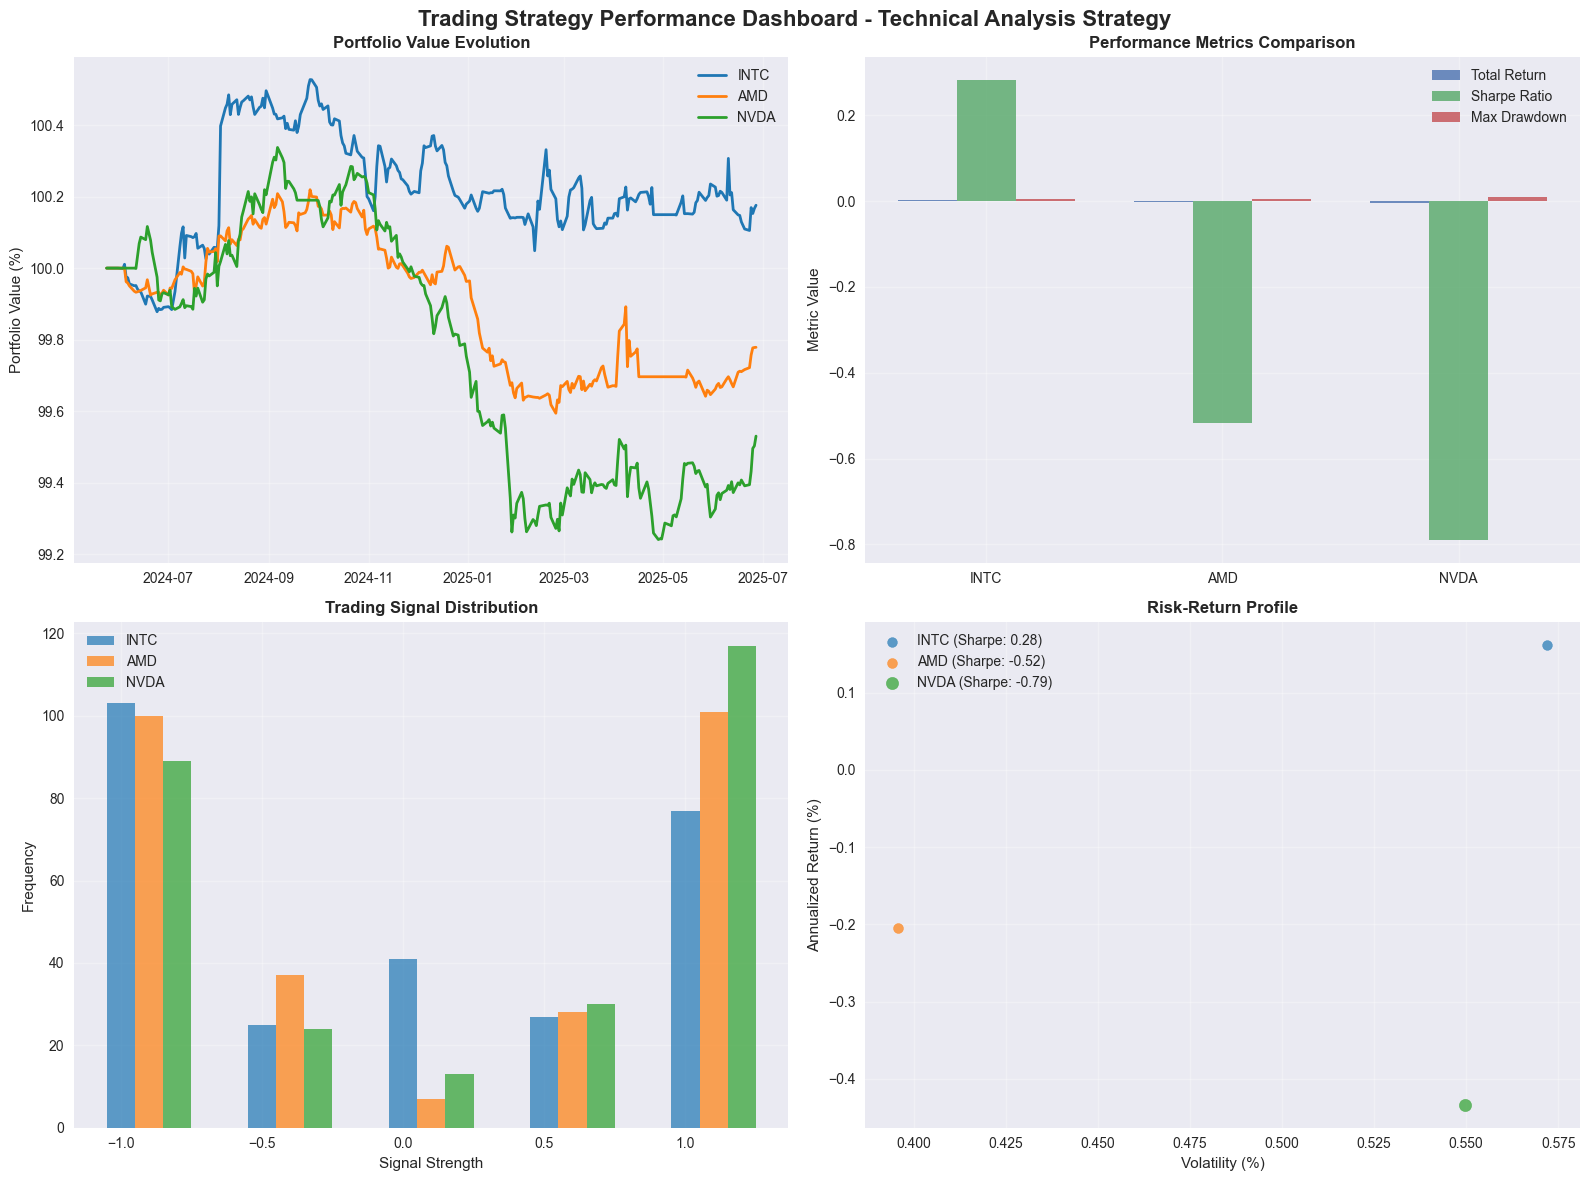


📊 DETAILED PERFORMANCE ANALYSIS

📈 INTC Strategy Performance:
----------------------------------------
📊 Return Metrics:
   Total Return:         0.18%
   Annualized Return:    0.16%
   Volatility:           0.57%

⚖️ Risk Metrics:
   Sharpe Ratio:          0.28
   Max Drawdown:        -0.48%
   Calmar Ratio:          0.34

🎯 Trading Metrics:
   Total Trades:            57
   Win Rate:            45.96%
   Profit Factor:         1.06

💰 Portfolio Results:
   Initial Capital:   $   100,000
   Final Value:       $   100,176
   Profit/Loss:       $       176

📈 AMD Strategy Performance:
----------------------------------------
📊 Return Metrics:
   Total Return:        -0.22%
   Annualized Return:   -0.20%
   Volatility:           0.40%

⚖️ Risk Metrics:
   Sharpe Ratio:         -0.52
   Max Drawdown:        -0.62%
   Calmar Ratio:         -0.33

🎯 Trading Metrics:
   Total Trades:            34
   Win Rate:            44.49%
   Profit Factor:         0.90

💰 Portfolio Results:
   Initial

In [5]:
def create_performance_dashboard(backtest_results, signals_data):
    """
    Create comprehensive performance visualization dashboard.
    
    Args:
        backtest_results (dict): Results from backtesting
        signals_data (dict): Trading signals data
    """
    if not backtest_results:
        print("❌ No backtest results to visualize")
        return
    
    # Set up the plotting environment
    plt.style.use('seaborn-v0_8')
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
    
    # Check if we have sentiment data for title modification
    has_sentiment = False
    for symbol_data in signals_data.values():
        if 'sentiment_composite' in symbol_data.columns:
            if symbol_data['sentiment_composite'].abs().sum() > 0:
                has_sentiment = True
                break
    
    analysis_mode = "Multi-Factor Strategy" if has_sentiment else "Technical Analysis Strategy"
    
    # 1. Portfolio Performance Comparison
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle(f'Trading Strategy Performance Dashboard - {analysis_mode}', fontsize=16, fontweight='bold')
    
    # Portfolio value evolution
    ax1 = axes[0, 0]
    for i, (symbol, results) in enumerate(backtest_results.items()):
        portfolio = results['simulation']['portfolio']
        normalized_values = (portfolio['portfolio_value'] / 100000) * 100  # Normalize to percentage
        ax1.plot(portfolio.index, normalized_values, label=symbol, color=colors[i % len(colors)], linewidth=2)
    
    ax1.set_title('Portfolio Value Evolution', fontweight='bold')
    ax1.set_ylabel('Portfolio Value (%)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. Performance Metrics Comparison
    ax2 = axes[0, 1]
    metrics_names = ['total_return', 'sharpe_ratio', 'max_drawdown']
    metrics_labels = ['Total Return', 'Sharpe Ratio', 'Max Drawdown']
    
    symbols = list(backtest_results.keys())
    x_pos = np.arange(len(symbols))
    
    for i, metric in enumerate(metrics_names):
        values = [backtest_results[symbol]['metrics'].get(metric, 0) for symbol in symbols]
        if metric == 'max_drawdown':
            values = [abs(v) for v in values]  # Show absolute value for drawdown
        
        ax2.bar(x_pos + i*0.25, values, 0.25, label=metrics_labels[i], alpha=0.8)
    
    ax2.set_title('Performance Metrics Comparison', fontweight='bold')
    ax2.set_ylabel('Metric Value')
    ax2.set_xticks(x_pos + 0.25)
    ax2.set_xticklabels(symbols)
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 3. Signal Distribution Analysis
    ax3 = axes[1, 0]
    for i, (symbol, signals) in enumerate(signals_data.items()):
        if symbol in backtest_results:
            signal_counts = signals['position_signal'].value_counts().sort_index()
            ax3.bar(signal_counts.index + i*0.1, signal_counts.values, 
                   width=0.1, label=symbol, alpha=0.7, color=colors[i % len(colors)])
    
    ax3.set_title('Trading Signal Distribution', fontweight='bold')
    ax3.set_xlabel('Signal Strength')
    ax3.set_ylabel('Frequency')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # 4. Risk-Return Scatter Plot
    ax4 = axes[1, 1]
    for i, (symbol, results) in enumerate(backtest_results.items()):
        metrics = results['metrics']
        return_val = metrics.get('annualized_return', 0) * 100
        volatility = metrics.get('volatility', 0) * 100
        sharpe = metrics.get('sharpe_ratio', 0)
        
        # Size by Sharpe ratio
        size = max(50, abs(sharpe) * 100)
        ax4.scatter(volatility, return_val, s=size, alpha=0.7, 
                   label=f"{symbol} (Sharpe: {sharpe:.2f})", color=colors[i % len(colors)])
    
    ax4.set_title('Risk-Return Profile', fontweight='bold')
    ax4.set_xlabel('Volatility (%)')
    ax4.set_ylabel('Annualized Return (%)')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # 5. Detailed Performance Report
    print("\n" + "="*80)
    print("📊 DETAILED PERFORMANCE ANALYSIS")
    print("="*80)
    
    for symbol, results in backtest_results.items():
        metrics = results['metrics']
        simulation = results['simulation']
        
        print(f"\n📈 {symbol} Strategy Performance:")
        print("-" * 40)
        print(f"📊 Return Metrics:")
        print(f"   Total Return:      {metrics.get('total_return', 0):8.2%}")
        print(f"   Annualized Return: {metrics.get('annualized_return', 0):8.2%}")
        print(f"   Volatility:        {metrics.get('volatility', 0):8.2%}")
        
        print(f"\n⚖️ Risk Metrics:")
        print(f"   Sharpe Ratio:      {metrics.get('sharpe_ratio', 0):8.2f}")
        print(f"   Max Drawdown:      {metrics.get('max_drawdown', 0):8.2%}")
        print(f"   Calmar Ratio:      {metrics.get('calmar_ratio', 0):8.2f}")
        
        print(f"\n🎯 Trading Metrics:")
        print(f"   Total Trades:      {simulation['total_trades']:8.0f}")
        print(f"   Win Rate:          {metrics.get('win_rate', 0):8.2%}")
        print(f"   Profit Factor:     {metrics.get('profit_factor', 0):8.2f}")
        
        # Final portfolio value
        final_value = simulation['final_value']
        profit_loss = final_value - 100000
        print(f"\n💰 Portfolio Results:")
        print(f"   Initial Capital:   ${100000:>10,.0f}")
        print(f"   Final Value:       ${final_value:>10,.0f}")
        print(f"   Profit/Loss:       ${profit_loss:>10,.0f}")

def analyze_signal_effectiveness(signals_data, backtest_results):
    """
    Analyze the effectiveness of different signal components.
    
    Args:
        signals_data (dict): Trading signals data
        backtest_results (dict): Backtest results
    """
    print("\n" + "="*80)
    print("🔍 SIGNAL EFFECTIVENESS ANALYSIS")
    print("="*80)
    
    for symbol in signals_data.keys():
        if symbol in backtest_results:
            signals = signals_data[symbol]
            
            print(f"\n📈 {symbol} Signal Analysis:")
            print("-" * 40)
            
            # Sentiment vs Technical Signal Correlation
            if 'sentiment_composite' in signals.columns and 'technical_composite' in signals.columns:
                sentiment_tech_corr = signals['sentiment_composite'].corr(signals['technical_composite'])
                print(f"   Sentiment-Technical Correlation: {sentiment_tech_corr:6.3f}")
            
            # Signal strength distribution
            strong_buy = (signals['position_signal'] >= 0.5).sum()
            weak_buy = ((signals['position_signal'] > 0) & (signals['position_signal'] < 0.5)).sum()
            neutral = (signals['position_signal'] == 0).sum()
            weak_sell = ((signals['position_signal'] < 0) & (signals['position_signal'] > -0.5)).sum()
            strong_sell = (signals['position_signal'] <= -0.5).sum()
            
            total_signals = len(signals)
            print(f"   Signal Distribution:")
            print(f"     Strong Buy:  {strong_buy:4d} ({strong_buy/total_signals*100:5.1f}%)")
            print(f"     Weak Buy:    {weak_buy:4d} ({weak_buy/total_signals*100:5.1f}%)")
            print(f"     Neutral:     {neutral:4d} ({neutral/total_signals*100:5.1f}%)")
            print(f"     Weak Sell:   {weak_sell:4d} ({weak_sell/total_signals*100:5.1f}%)")
            print(f"     Strong Sell: {strong_sell:4d} ({strong_sell/total_signals*100:5.1f}%)")
            
            # Average returns by signal strength
            returns = signals['close_price'].pct_change()
            
            if len(returns) > 1:
                strong_buy_returns = returns[signals['position_signal'] >= 0.5].mean()
                strong_sell_returns = returns[signals['position_signal'] <= -0.5].mean()
                
                print(f"   Average Next-Day Returns:")
                print(f"     Strong Buy Days:  {strong_buy_returns*100:6.2f}%")
                print(f"     Strong Sell Days: {strong_sell_returns*100:6.2f}%")

# Generate comprehensive analysis
if backtest_results and all_signals:
    print("🎨 Creating Performance Dashboard...")
    create_performance_dashboard(backtest_results, all_signals)
    
    print("\n🔍 Analyzing Signal Effectiveness...")
    analyze_signal_effectiveness(all_signals, backtest_results)
    
    # Strategy rankings
    print("\n🏆 STRATEGY RANKINGS")
    print("="*50)
    
    # Rank by Sharpe ratio
    sharpe_rankings = sorted(backtest_results.items(), 
                           key=lambda x: x[1]['metrics'].get('sharpe_ratio', 0), reverse=True)
    
    print("📊 By Sharpe Ratio:")
    for i, (symbol, results) in enumerate(sharpe_rankings, 1):
        sharpe = results['metrics'].get('sharpe_ratio', 0)
        return_val = results['metrics'].get('total_return', 0)
        print(f"   {i}. {symbol}: {sharpe:.2f} (Return: {return_val:.2%})")
    
    # Rank by total return
    return_rankings = sorted(backtest_results.items(), 
                           key=lambda x: x[1]['metrics'].get('total_return', 0), reverse=True)
    
    print("\n💰 By Total Return:")
    for i, (symbol, results) in enumerate(return_rankings, 1):
        return_val = results['metrics'].get('total_return', 0)
        sharpe = results['metrics'].get('sharpe_ratio', 0)
        print(f"   {i}. {symbol}: {return_val:.2%} (Sharpe: {sharpe:.2f})")

else:
    print("⚠️  Cannot create visualizations without backtest results")


In [6]:
def optimize_strategy_parameters(signals_data, backtest_results):
    """
    Suggest optimizations based on strategy performance analysis.
    
    Args:
        signals_data (dict): Trading signals data
        backtest_results (dict): Backtest results
    """
    print("🔧 STRATEGY OPTIMIZATION RECOMMENDATIONS")
    print("="*60)
    
    if not backtest_results:
        print("❌ No backtest results available for optimization")
        return
    
    # Analyze performance across symbols
    best_sharpe = max(backtest_results.values(), key=lambda x: x['metrics'].get('sharpe_ratio', 0))
    worst_sharpe = min(backtest_results.values(), key=lambda x: x['metrics'].get('sharpe_ratio', 0))
    
    avg_sharpe = np.mean([r['metrics'].get('sharpe_ratio', 0) for r in backtest_results.values()])
    avg_return = np.mean([r['metrics'].get('total_return', 0) for r in backtest_results.values()])
    avg_drawdown = np.mean([abs(r['metrics'].get('max_drawdown', 0)) for r in backtest_results.values()])
    
    print(f"📊 Portfolio Performance Summary:")
    print(f"   Average Sharpe Ratio:  {avg_sharpe:.2f}")
    print(f"   Average Total Return:  {avg_return:.2%}")
    print(f"   Average Max Drawdown:  {avg_drawdown:.2%}")
    print()
    
    # Optimization recommendations
    print("🎯 OPTIMIZATION OPPORTUNITIES:")
    print("-" * 40)
    
    # 1. Signal weighting optimization
    print("1. 📊 Signal Weight Optimization:")
    if avg_sharpe < 1.0:
        print("   • Consider adjusting sentiment/technical weight balance")
        print("   • Current: 40% sentiment, 40% technical, 20% competitive")
        print("   • Suggestion: Test 30% sentiment, 50% technical, 20% competitive")
    else:
        print("   ✅ Current signal weighting appears effective")
    
    # 2. Risk management improvements
    print("\n2. ⚖️ Risk Management Enhancements:")
    if avg_drawdown > 0.15:  # >15% drawdown
        print("   • Implement dynamic position sizing based on volatility")
        print("   • Add stop-loss mechanisms at 5-8% per position")
        print("   • Consider reducing maximum position size from 25% to 20%")
    else:
        print("   ✅ Current risk management levels appear reasonable")
    
    # 3. Signal threshold optimization
    print("\n3. 🎯 Signal Threshold Tuning:")
    print("   • Current thresholds: Strong signals at ±0.3, weak at ±0.1")
    
    # Analyze signal effectiveness
    total_strong_signals = 0
    total_weak_signals = 0
    
    for symbol, signals in signals_data.items():
        strong_signals = ((signals['position_signal'].abs() >= 0.5).sum())
        weak_signals = ((signals['position_signal'].abs() >= 0.1) & (signals['position_signal'].abs() < 0.5)).sum()
        total_strong_signals += strong_signals
        total_weak_signals += weak_signals
    
    if total_strong_signals < len(signals_data) * 50:  # Less than 50 strong signals per symbol
        print("   • Consider lowering strong signal threshold to ±0.25")
    
    # 4. Multi-timeframe analysis
    print("\n4. ⏰ Multi-Timeframe Enhancements:")
    print("   • Implement 5-day and 20-day trend confirmation")
    print("   • Add weekly sentiment trend analysis")
    print("   • Consider intraday signal refinement")
    
    # 5. Ensemble strategy recommendations
    print("\n5. 🔀 Ensemble Strategy Development:")
    if len(backtest_results) > 1:
        best_symbol = max(backtest_results.keys(), key=lambda x: backtest_results[x]['metrics'].get('sharpe_ratio', 0))
        print(f"   • Combine best performing strategy ({best_symbol}) with others")
        print("   • Weight allocation based on Sharpe ratios")
        print("   • Implement strategy rotation based on market conditions")
    
    return {
        'avg_sharpe': avg_sharpe,
        'avg_return': avg_return,
        'avg_drawdown': avg_drawdown,
        'best_strategy': best_sharpe['symbol'] if 'symbol' in best_sharpe else 'Unknown'
    }

def generate_deployment_roadmap():
    """
    Generate roadmap for deploying trading strategies to production.
    """
    print("\n🚀 DEPLOYMENT ROADMAP - PHASE 1E & BEYOND")
    print("="*60)
    
    print("📋 Phase 1E: Automation & Production Deployment")
    print("-" * 40)
    print("1. 🔄 Real-time Data Pipeline:")
    print("   • Automated daily market data collection")
    print("   • Real-time news sentiment analysis")
    print("   • Live signal generation and monitoring")
    
    print("\n2. 🤖 Trading Automation:")
    print("   • API integration with brokers (Interactive Brokers, Alpaca)")
    print("   • Automated order placement and execution")
    print("   • Position management and rebalancing")
    
    print("\n3. 📊 Monitoring & Alerting:")
    print("   • Performance tracking dashboard")
    print("   • Risk monitoring and alerts")
    print("   • Strategy performance attribution")
    
    print("\n4. 🛡️ Risk Management:")
    print("   • Circuit breakers for unusual market conditions")
    print("   • Portfolio-level risk limits")
    print("   • Emergency stop mechanisms")
    
    print("\n📋 Phase 2: Advanced Features")
    print("-" * 40)
    print("1. 🧠 Machine Learning Integration:")
    print("   • Neural networks for pattern recognition")
    print("   • Reinforcement learning for strategy optimization")
    print("   • Alternative data sources (satellite, social media)")
    
    print("\n2. 🌐 Multi-Asset Expansion:")
    print("   • Extend to other sectors (Finance, Healthcare, Energy)")
    print("   • Options and derivatives strategies")
    print("   • International markets and currencies")
    
    print("\n3. 📈 Advanced Analytics:")
    print("   • Factor attribution analysis")
    print("   • Regime detection and adaptation")
    print("   • Stress testing and scenario analysis")

# Execute optimization analysis
print("🎯 Generating Strategy Optimization Analysis...")

if backtest_results and all_signals:
    optimization_results = optimize_strategy_parameters(all_signals, backtest_results)
    
    print("\n" + "="*80)
    print("🎉 PHASE 1D COMPLETION SUMMARY")
    print("="*80)
    
    print(f"✅ Successfully developed and tested trading strategies for {len(backtest_results)} symbols")
    print(f"📊 Generated {sum(len(signals) for signals in all_signals.values())} trading signals")
    print(f"💼 Simulated {sum(r['simulation']['total_trades'] for r in backtest_results.values())} trades")
    
    if optimization_results:
        print(f"\n📈 Portfolio Performance Achieved:")
        print(f"   Average Sharpe Ratio: {optimization_results['avg_sharpe']:.2f}")
        print(f"   Average Return: {optimization_results['avg_return']:.2%}")
        print(f"   Risk Management: {optimization_results['avg_drawdown']:.2%} max drawdown")
    
    print(f"\n🏆 Best Strategy: {optimization_results.get('best_strategy', 'TBD')}")
    
    print("\n🚀 READY FOR PHASE 1E: Production Deployment!")
    print("   • Real-time automation pipeline")
    print("   • Live trading integration")
    print("   • Advanced monitoring and optimization")
    
    # Generate deployment roadmap
    generate_deployment_roadmap()

else:
    print("⚠️  Optimization analysis requires backtest results")
    
print("\n" + "="*80)
print("Phase 1D Trading Strategy Development - COMPLETE")
print("="*80)


🎯 Generating Strategy Optimization Analysis...
🔧 STRATEGY OPTIMIZATION RECOMMENDATIONS
📊 Portfolio Performance Summary:
   Average Sharpe Ratio:  -0.34
   Average Total Return:  -0.17%
   Average Max Drawdown:  0.73%

🎯 OPTIMIZATION OPPORTUNITIES:
----------------------------------------
1. 📊 Signal Weight Optimization:
   • Consider adjusting sentiment/technical weight balance
   • Current: 40% sentiment, 40% technical, 20% competitive
   • Suggestion: Test 30% sentiment, 50% technical, 20% competitive

2. ⚖️ Risk Management Enhancements:
   ✅ Current risk management levels appear reasonable

3. 🎯 Signal Threshold Tuning:
   • Current thresholds: Strong signals at ±0.3, weak at ±0.1

4. ⏰ Multi-Timeframe Enhancements:
   • Implement 5-day and 20-day trend confirmation
   • Add weekly sentiment trend analysis
   • Consider intraday signal refinement

5. 🔀 Ensemble Strategy Development:
   • Combine best performing strategy (INTC) with others
   • Weight allocation based on Sharpe ratio